In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import nltk
from nltk import pos_tag
from nltk.probability import FreqDist
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer, PorterStemmer, SnowballStemmer
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re

In [3]:
df = pd.read_csv('../data/brands_and_product_tweets.csv')
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8721 entries, 0 to 8720
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          8720 non-null   object
 1   emotion_in_tweet_is_directed_at                     3169 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  8721 non-null   object
dtypes: object(3)
memory usage: 204.5+ KB


In [5]:
df.emotion_in_tweet_is_directed_at.value_counts()

iPad                               910
Apple                              640
iPad or iPhone App                 451
Google                             412
iPhone                             288
Other Google product or service    282
Android App                         78
Android                             74
Other Apple product or service      34
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [6]:
df.is_there_an_emotion_directed_at_a_brand_or_product.value_counts()

No emotion toward brand or product    5156
Positive emotion                      2869
Negative emotion                       545
I can't tell                           151
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [7]:
sw = stopwords.words('english')
tokenizer = RegexpTokenizer(r"(?u)\w{3,}")
# pattern to grab words with 3 characters or more
lemmer = WordNetLemmatizer()
#p_stemmer = PorterStemmer()
#s_stemmer = SnowballStemmer()

Define a function so that inputted text is lower cased, tokenized, stop words removed, & lemmed.

In [ ]:
#def pre_text(text, tokenizer, sw, lemmer):
#    text_lower = text.lower()
#    tokens = tokenizer.tokenize(text_lower)
#    tokens_filtered = [token for token in tokens if token not in sw]
#    tokens_lemmed = [lemmer.lemmatize(token) for token in tokens]

In [8]:
def clean_text(text):
    # Check if the text is a string
    if not isinstance(text, str):
        return ''  # Return empty string if text is not a string
    # Remove URLs items
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove user @ references and '#' from tweet
    text = re.sub(r'\@\w+|\#','', text)
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    # Remove special characters and numbers
    text = re.sub(r"[^a-zA-Z']", ' ', text)
    # Convert to lowercase
    text = text.lower()
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    
    return text

# Clean the tweet_text column
#df['cleaned_tweet_text'] = df['tweet_text'].apply(clean_text)

In [9]:
# Function to lemmatize text
def lemmatize_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    # Lemmatize each word
    lemmatized_tokens = [lemmer.lemmatize(token) for token in tokens]
    # Rejoin lemmatized tokens into a string
    lemmatized_text = ' '.join(lemmatized_tokens)
    return lemmatized_text

# Example text
example_text = "Fall Out Boy Rules."

# Lemmatize the example text
lemmatized_text = lemmatize_text(example_text)
print(lemmatized_text)

Fall Out Boy Rules .


In [10]:
df['cleaned_text'] = df['tweet_text'].apply(clean_text)

df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,cleaned_text
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,g iphone hrs tweeting rise austin dead need up...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,know awesome ipad iphone app likely appreciate...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,wait ipad also sale sxsw
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,hope year's festival crashy year's iphone app ...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,great stuff fri sxsw marissa mayer google tim ...


In [11]:
df['lemmatized_text'] = df['cleaned_text'].apply(lemmatize_text)

df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product,cleaned_text,lemmatized_text
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion,g iphone hrs tweeting rise austin dead need up...,g iphone hr tweeting rise austin dead need upg...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion,know awesome ipad iphone app likely appreciate...,know awesome ipad iphone app likely appreciate...
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion,wait ipad also sale sxsw,wait ipad also sale sxsw
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion,hope year's festival crashy year's iphone app ...,hope year 's festival crashy year 's iphone ap...
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion,great stuff fri sxsw marissa mayer google tim ...,great stuff fri sxsw marissa mayer google tim ...


In [12]:
# Instantiate CountVectorizer
count_vectorizer = CountVectorizer()

# Use CountVectorizer on the lemmatized text
count_matrix = count_vectorizer.fit_transform(df['lemmatized_text'])

In [14]:
# Convert the count matrix to a DataFrame
count_df = pd.DataFrame(count_matrix.toarray(), columns=count_vectorizer.get_feature_names())

In [16]:
count_df.head()

,aapl,aaron,ab,abacus,abandoned,abba,abc,aber,ability,able,...,zlf,zms,zomb,zombie,zomg,zone,zoom,zuckerberg,zynga,zzzs
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
# Display the frequency table
freq_table = count_df.sum(axis=0).sort_values(ascending=False).reset_index()
freq_table.columns = ['Term', 'Frequency']
print(freq_table)

        Term  Frequency
0       sxsw       9271
1       link       4131
2         rt       2959
3       ipad       2894
4     google       2552
...      ...        ...
8161     luv          1
8162  luxury          1
8163     lwr          1
8164  lybian          1
8165    lend          1

[8166 rows x 2 columns]


In [18]:
type(count_df)

pandas.core.frame.DataFrame

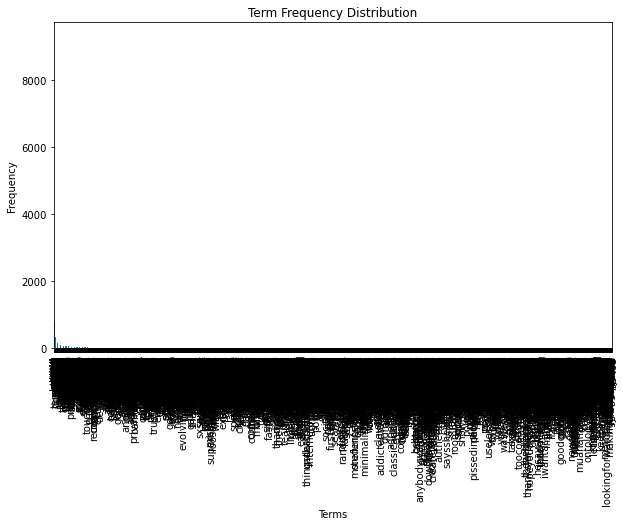

In [19]:
# Calculate term frequencies
term_frequencies = count_df.sum(axis=0)

# Plot the frequency distribution
plt.figure(figsize=(10, 6))
term_frequencies.sort_values(ascending=False).plot(kind='bar')
plt.title('Term Frequency Distribution')
plt.xlabel('Terms')
plt.ylabel('Frequency')
plt.show()

In [20]:
count_df.value_counts()

aapl  aaron  ab  abacus  abandoned  abba  abc  aber  ability  able  abnormal  abound  absolute  absolutely  absolutley  abt  abuzz  academy  acc  accelerater  accept  acceptable  access  accessibility  accessible  accessory  accesssxsw  accidentally  accommodate  accompanied  accomplish  according  accordion  account  accuracy  acerbic  achieve  achievement  ackers  acknowledge  ackward  aclu  aclus  acoustic  acquired  acquisition  across  acrosse  act  acting  action  actionable  activate  activation  activity  actor  actsofsharing  actual  actually  ad  adam  adapt  adapter  adapting  adaptive  add  added  addict  addicted  addictedtotheinterwebs  addiction  addictive  addition  additional  addr  address  adele  adfonic  adi  adloopz  admired  admission  admit  admits  admitting  admob  ado  adobe  adopter  adoption  adpeopleproblems  advance  advanced  advantage  advent  adventure  advertising  advice  advil  advising  advisory  advocate  adwords  ae  aesthetic  afar  affair  affec

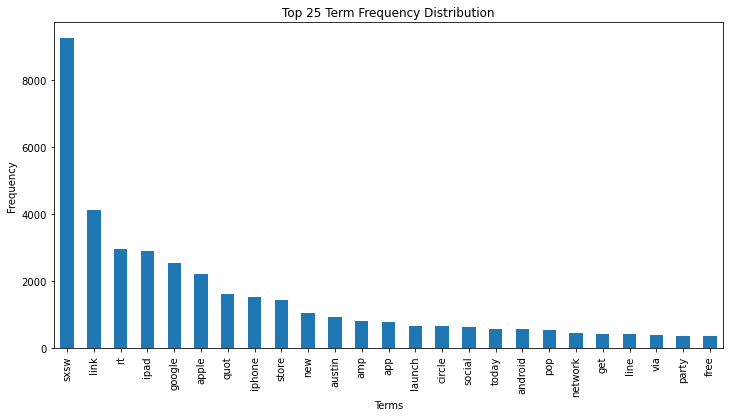

In [23]:
# top 25 terms selected
top_25_terms = term_frequencies.sort_values(ascending=False).head(25)

# Plot the top 25 terms in the frequency distribution
plt.figure(figsize=(12, 6))
top_25_terms.plot(kind='bar')
plt.title('Top 25 Term Frequency Distribution')
plt.xlabel('Terms')
plt.ylabel('Frequency')
plt.show()